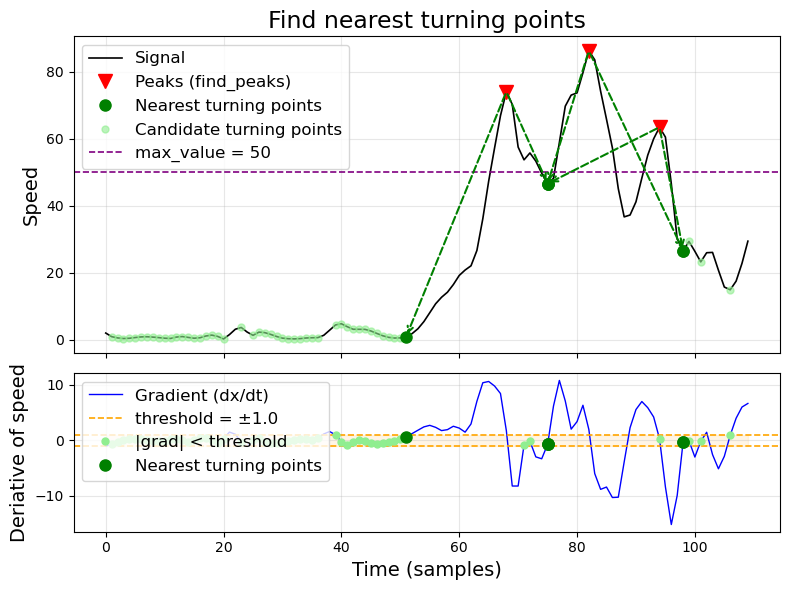

In [25]:
import numpy as np                                                                                                      
import matplotlib.pyplot as plt
from scipy.signal import find_peaks  
from ethograph import TrialTree                                                                                                                                                                              

path = r"C:\Users\aksel\Desktop\FreddyTrain\Trial_data2701.nc"
dt = TrialTree.open(path)
values = dt.itrial(21).speed.sel(keypoints="beakTip").squeeze().values
x = values[510:620].copy()
t = np.arange(len(x))

# Parameters
threshold = 1.0
max_value = 50
prominence = 5
width = 2

# Compute gradient and find turning points
grad = np.gradient(x)
turning_mask = (grad > -threshold) & (grad < threshold)
turning_points = np.where(turning_mask)[0]

if max_value is not None:
    turning_points = turning_points[x[turning_points] < max_value]

# Find peaks
peaks, _ = find_peaks(x, prominence=prominence, width=width)
turning_points = np.setdiff1d(turning_points, peaks)

# For each peak, find nearest turning point left and right
nearest = []
for peak in peaks:
    left = turning_points[turning_points < peak]
    right = turning_points[turning_points > peak]
    if len(left) > 0:
        nearest.append(left[-1])
    if len(right) > 0:
        nearest.append(right[0])
nearest = np.array(nearest, dtype=int)

# --- Figure ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex=True,
                                gridspec_kw={'height_ratios': [2, 1]})

# Top: signal + peaks + turning points + max_value line
ax1.plot(t, x, 'k-', lw=1.2, label='Signal')
ax1.plot(peaks, x[peaks], 'rv', ms=10, label='Peaks (find_peaks)')
ax1.plot(nearest, x[nearest], 'go', ms=8, zorder=5, label='Nearest turning points')

# Shade candidate turning point regions on signal
tp_all = np.where(turning_mask)[0]
tp_below_max = tp_all[x[tp_all] < max_value] if max_value is not None else tp_all
ax1.plot(tp_below_max, x[tp_below_max], '.', color='lightgreen', ms=10, alpha=0.6,
        label='Candidate turning points')

# max_value horizontal line
ax1.axhline(max_value, color='purple', ls='--', lw=1.2, label=f'max_value = {max_value}')

# Draw arrows from each peak to its nearest turning points
for peak in peaks:
    left = turning_points[turning_points < peak]
    right = turning_points[turning_points > peak]
    if len(left) > 0:
        ax1.annotate('', xy=(left[-1], x[left[-1]]), xytext=(peak, x[peak]),
                    arrowprops=dict(arrowstyle='->', color='green', lw=1.5, ls='--'))
    if len(right) > 0:
        ax1.annotate('', xy=(right[0], x[right[0]]), xytext=(peak, x[peak]),
                    arrowprops=dict(arrowstyle='->', color='green', lw=1.5, ls='--'))

ax1.set_ylabel('Speed', fontsize=14)
ax1.legend(loc='upper left', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.set_title('Find nearest turning points', fontsize=17)


# Bottom: gradient + threshold band
ax2.plot(t, grad, 'b-', lw=1, label='Gradient (dx/dt)')
ax2.axhline(threshold, color='orange', ls='--', lw=1.2, label=f'threshold = ±{threshold}')
ax2.axhline(-threshold, color='orange', ls='--', lw=1.2)
ax2.fill_between(t, -threshold, threshold, color='orange', alpha=0.1)

# Mark where gradient is within threshold (candidate turning points)
in_band = np.where(turning_mask)[0]
ax2.plot(in_band, grad[in_band], '.', color='lightgreen', ms=10, alpha=1,
        label='|grad| < threshold')

# Mark the selected nearest turning points on gradient too
ax2.plot(nearest, grad[nearest], 'go', ms=8, zorder=5, label='Nearest turning points')

ax2.set_xlabel('Time (samples)', fontsize=14)
ax2.set_ylabel('Deriative of speed', fontsize=14)
ax2.legend(loc='upper left', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()